In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
from collections import namedtuple, deque
from random import choices

/home2/dhruv.kapur/anaconda3/envs/rl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

In [4]:
class ReplayBuffer:

    def __init__(self, max_len=10000):
        self.memory = deque([], maxlen=max_len)

    def push(self, experience):
        self.memory.append(experience)

    def sample(self, k):
        experiences = choices(self.memory, k=k)

        states = torch.cat([e.state for e in experiences], 0).to(device).float()
        actions = torch.cat([e.action for e in experiences], 0).to(device).float()
        next_states = torch.cat([e.next_state for e in experiences], 0).to(device).float()
        rewards = torch.cat([e.reward for e in experiences], 0).to(device).float()
        done = torch.cat([e.done for e in experiences], 0).to(device)

        return states, actions, next_states, rewards, done
    
    def __len__(self):
        return len(self.memory)

In [5]:
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


In [6]:
class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1

In [15]:
class TD3:

    def __init__(self, env, gamma=0.99, batch_size=64, memory_size=100000, min_experiences=1000, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        self.state_shape = env.observation_space.shape[0]
        self.action_shape = env.action_space.shape[0]
        self.max_action = env.action_space.high[0]
        self.env = env

        self.gamma = gamma

        self.actor = Actor(self.state_shape, self.action_shape, self.max_action).to(device)
        self.target_actor = Actor(self.state_shape, self.action_shape, self.max_action).to(device)
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.critic = Critic(self.state_shape, self.action_shape).to(device)
        self.target_critic = Critic(self.state_shape, self.action_shape)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.replay_buffer = ReplayBuffer(memory_size)

        self.critic_criterion = nn.MSELoss()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.batch_size = batch_size
        self.tau = tau
        self.min_experiences = min_experiences
        self.policy_noise = policy_noise
        self.policy_freq = policy_freq
        self.noise_clip = noise_clip

    def select_action(self, state):
        return self.actor(state).detach().cpu().numpy().flatten()
        
    def tensorify(self, x):
        return torch.tensor(x).unsqueeze(0).to(device)

    def learn(self, n_episodes=1000) -> list:
        
        rewards = []
        critic_losses = []
        actor_losses = []

        for ep in tqdm(range(n_episodes)):
            curr_ep_rew = 0
            curr_ep_critic_losses = []
            curr_ep_actor_losses = []
            step = 0
            state = self.tensorify(self.env.reset())
            while True:

                if len(self.replay_buffer) < self.min_experiences:
                    action = self.tensorify(self.env.action_space.sample())
                else:
                    noise = self.tensorify(np.random.normal(0, self.max_action * 0.1, size=self.action_shape))
                    action = self.tensorify(self.select_action(state))
                    action = (action + noise).clamp(-self.max_action, self.max_action)

                next_state, reward, done, info = self.env.step(action.squeeze(0).cpu().numpy())

                curr_ep_rew += reward

                next_state = self.tensorify(next_state)
                reward = self.tensorify([reward])
                done = self.tensorify([done])

                self.replay_buffer.push(Experience(state, action, next_state, reward, done))

                curr_step_critic_loss, curr_step_actor_loss = self.update_networks(step)

                if curr_step_critic_loss is not None:
                    curr_ep_critic_losses.append(curr_step_critic_loss)
                if curr_step_actor_loss is not None:
                    curr_ep_actor_losses.append(curr_step_actor_loss)

                if done:
                    break

                state = next_state
                step += 1
            
            rewards.append(curr_ep_rew)
            critic_losses.append(sum(curr_ep_critic_losses)/len(curr_ep_critic_losses) if len(curr_ep_critic_losses) > 0 else np.nan)
            actor_losses.append(sum(curr_ep_actor_losses)/len(curr_ep_actor_losses) if len(curr_ep_actor_losses) > 0 else np.nan)
        
        return rewards, critic_losses, actor_losses

    def update_networks(self, step):
        
        if len(self.replay_buffer) < self.min_experiences:
            return [None, None]

        batch_states, batch_actions, batch_next_states, batch_rewards, batch_dones = self.replay_buffer.sample(self.batch_size)

        with torch.no_grad():

            noise = (torch.randn_like(batch_actions) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            batch_next_actions = (self.target_actor(batch_next_states) + noise).clamp(-self.max_action, self.max_action)

            target_Q1, target_Q2 = self.target_critic(batch_next_states, batch_next_actions)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q[batch_dones] = 0.0
            target_Q = batch_rewards + self.gamma * target_Q
        
        current_Q1, current_Q2 = self.critic(batch_states, batch_actions)


        critic_loss = self.critic_criterion(current_Q1, target_Q) + self.critic_criterion(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        losses = [critic_loss.item(), None]

        if step % self.policy_freq == 0:

            actor_loss = -self.critic.Q1(batch_states, self.actor(batch_states)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            losses[-1] = actor_loss.item()

            self.soft_update(self.target_actor, self.actor)
            self.soft_update(self.target_critic, self.critic)

        return losses
        
    def soft_update(self, target_net, net):

        for param, target_param in zip(net.parameters(), target_net.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param + self.tau * param)

    def save_policy(self, path):
        torch.save(self.actor.state_dict(), path)


In [16]:
env = gym.make('Pendulum-v1')

In [17]:
agent = TD3(env)

In [18]:
rewards, critic_losses, actor_losses = agent.learn()

100%|██████████| 1000/1000 [32:19<00:00,  1.94s/it]


In [19]:
mean_over = 100
mean_rewards = [sum(rewards[:i])/i for i in range(1, mean_over - 1)] + [sum(rewards[i-mean_over:i])/mean_over for i in range(mean_over, len(rewards))]
mean_critic_losses = [sum(critic_losses[:i])/i for i in range(1, mean_over - 1)] + [sum(critic_losses[i-mean_over:i])/mean_over for i in range(mean_over, len(critic_losses))]
mean_actor_losses = [sum(actor_losses[:i])/i for i in range(1, mean_over - 1)] + [sum(actor_losses[i-mean_over:i])/mean_over for i in range(mean_over, len(actor_losses))]

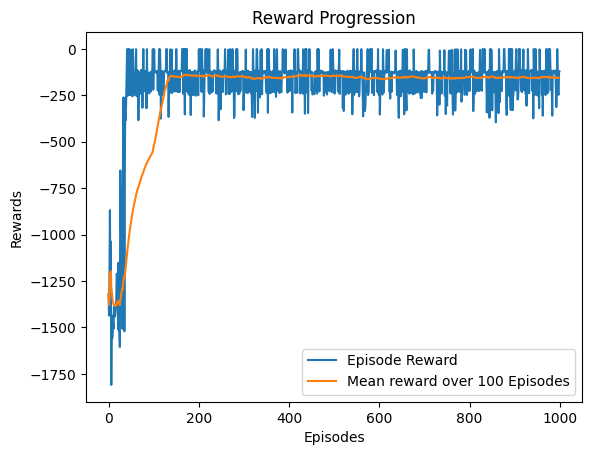

In [20]:
plt.plot(range(len(rewards)), rewards)
plt.plot(range(len(mean_rewards)), mean_rewards)
plt.title("Reward Progression")
plt.legend(["Episode Reward", "Mean reward over 100 Episodes"])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

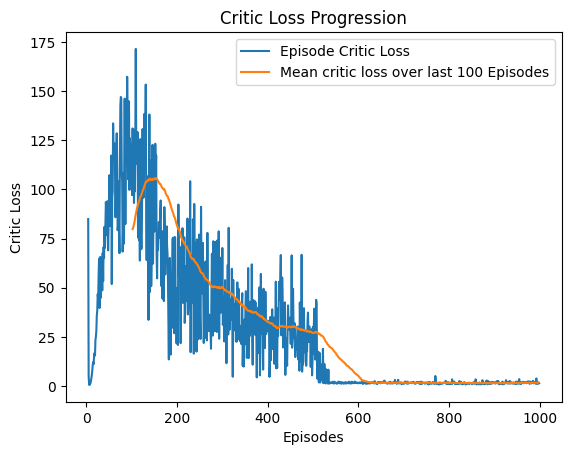

In [21]:
plt.plot(range(len(critic_losses)), critic_losses)
plt.plot(range(len(mean_critic_losses)), mean_critic_losses)
plt.title("Critic Loss Progression")
plt.legend(["Episode Critic Loss", "Mean critic loss over last 100 Episodes"])
plt.xlabel("Episodes")
plt.ylabel("Critic Loss")
plt.show()

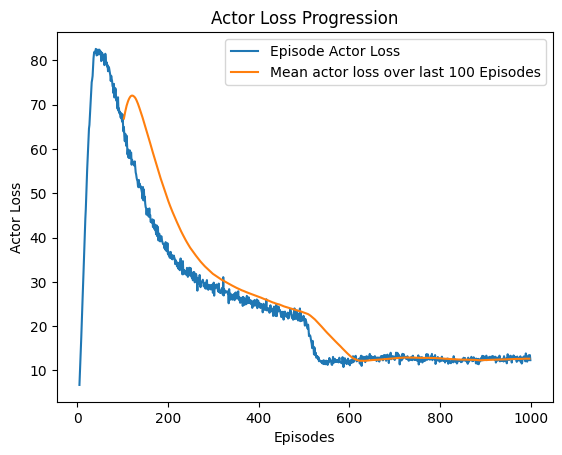

In [22]:
plt.plot(range(len(actor_losses)), actor_losses)
plt.plot(range(len(mean_actor_losses)), mean_actor_losses)
plt.title("Actor Loss Progression")
plt.legend(["Episode Actor Loss", "Mean actor loss over last 100 Episodes"])
plt.xlabel("Episodes")
plt.ylabel("Actor Loss")
plt.show()